# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [3]:
# Positive constant
M, G, q, mu1, mu2, m1, m2, b1, b2, j, b1_3_2, b2_3_2 = symbols(
    r"M G q mu_1 mu_2 m_1, m_2, beta_1 beta_2 j b_{3/2}^{(1)}(\alpha_0) b_{3/2}^{(2)}(\alpha_0)",
    positive=True,
)
# Positive timescales
Tm1, Tm2, Te1, Te2 = symbols(
    r"T_{m\,1} T_{m\,2} T_{e\,1} T_{e\,2}",
    positive=True,
)
# Precession frequencies
om1, om2 = symbols("omega_1 omega_2")
# Angles of time
l1, l2, pom1, pom2, th1, th2, th0 = symbols(
    "l_1 l_2 varpi_1 varpi_2 theta_1 theta_2 theta_0"
)
# Positive functions of time
e1, e2, a1, a2, n1, n2, alpha = symbols("e_1 e_2 a_1 a_2 n_1 n_2 alpha", positive=True)
# Actions
Gam1, Gam2, Lam1, Lam2 = symbols("Gamma_1 Gamma_2 Lambda_1 Lambda_2", positive=True)
# Derivatives
dth1, dth2 = symbols(r"\dot\theta_1 \dot\theta_2")

In [4]:
EXPRS = {}
EXPRS[th1] = (j + 1) * l2 - j * l1 - pom1
EXPRS[th2] = (j + 1) * l2 - j * l1 - pom2
EXPRS[Lam1] = q * sqrt(a1)
EXPRS[Lam2] = sqrt(a2)
EXPRS[Gam1] = Rational(1, 2) * q * sqrt(a1) * e1**2
EXPRS[Gam2] = Rational(1, 2) * sqrt(a2) * e2**2

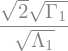

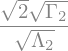

In [ ]:
CANON = {}
CANON[a1] = solve(EXPRS[Lam1] - Lam1, a1)[0]
CANON[e1] = solve(EXPRS[Gam1] - Gam1, e1)[0].subs(a1, CANON[a1])
CANON[a2] = solve(EXPRS[Lam2] - Lam2, a2)[0]
CANON[e2] = solve(EXPRS[Gam2] - Gam2, e2)[0].subs(a2, CANON[a2])
display(CANON[a1])
display(CANON[e1])
display(CANON[a2])
display(CANON[e2])

In [6]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return run


def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term * mult
    term_simplify(run)
    return run


def chain_rule(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key) * EXPRS[key].diff(var)
    for key in CANON.keys():
        run += expr.diff(key) * CANON[key].diff(var)
    return run


def to_orbelts(expr):
    for var in [Lam1, Lam2, Gam1, Gam2]:
        expr = expr.subs(var, EXPRS[var])
    return expr

- Assume $a_2\approx a_{2,0}[=1]$ in denominator of perturbation term.
- $\beta_1=-f_{27}(\alpha_0)$ and $\beta_2=f_{31}(\alpha_0)$ 

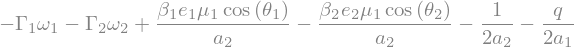

In [ ]:
H_expr = (
    -Rational(1, 2) * q / a1
    - Rational(1, 2) * 1 / a2
    + mu1 * b1 * e1 * cos(th1) / a2
    - mu1 * b2 * e2 * cos(th2) / a2
    - Gam1 * om1
    - Gam2 * om2
)
H_expr

Doing 2 different R_i for each planet to reduce typos over from Murray & Dermott.

Units are in $[n_{2,0}]$, $[a_{2,0}]$, and $[M]$

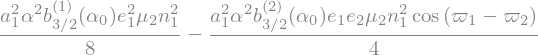

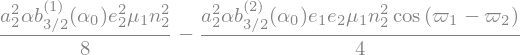

In [ ]:
# A11 = Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b1_3_2
# A12 = -Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b2_3_2
# A21 = -Rational(1,4)*n2*m1/(M+m2)*alpha*b2_3_2
# A22 = Rational(1,4)*n2*m1/(M+m2)*alpha*b1_3_2
A11 = Rational(1, 4) * n1 * mu2 * alpha * alpha * b1_3_2
A12 = -Rational(1, 4) * n1 * mu2 * alpha * alpha * b2_3_2
A21 = -Rational(1, 4) * n2 * mu1 * alpha * b2_3_2
A22 = Rational(1, 4) * n2 * mu1 * alpha * b1_3_2

R1 = (
    n1 * a1**2 * (Rational(1, 2) * A11 * e1**2 + A12 * e1 * e2 * cos(pom1 - pom2))
).expand()
R2 = (
    n2 * a2**2 * (Rational(1, 2) * A22 * e2**2 + A21 * e1 * e2 * cos(pom1 - pom2))
).expand()
# term_multiply(R1.expand().subs(n1**2,G*M*m1/a1**3),1/(G*M*m2)).subs({m1:mu1*M,m2:mu2*M}).cancel()
display(R1)
display(R2)

# Equations of motion

## Resonant

### $\dot\Lambda_1$, $\dot\Lambda_2$

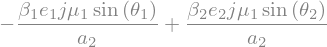

In [ ]:
Lam1_dot_res = -chain_rule(H_expr, l1)
Lam1_dot_res

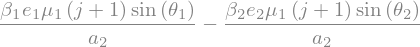

In [ ]:
Lam2_dot_res = -chain_rule(H_expr, l2)
Lam2_dot_res

### $\dot n_1$, $\dot n_2$

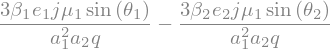

In [11]:
n1_dot_res = term_multiply(Lam1_dot_res, -3 * q**3 / Lam1**4).subs(Lam1, EXPRS[Lam1])
n1_dot_res

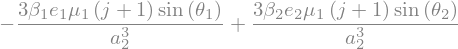

In [ ]:
n2_dot_res = term_multiply(Lam2_dot_res, -3 / Lam2**4).subs(Lam2, EXPRS[Lam2])
n2_dot_res

### $\dot\Gamma_1$, $\dot\Gamma_2$

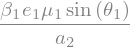

In [ ]:
Gam1_dot_res = chain_rule(H_expr, pom1)
Gam1_dot_res

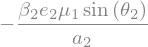

In [ ]:
Gam2_dot_res = chain_rule(H_expr, pom2)
Gam2_dot_res

### $\dot\varpi_1$, $\dot\varpi_2$

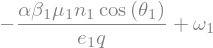

In [ ]:
pom1_dot_res = (
    to_orbelts(-chain_rule(H_expr, Gam1))
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
pom1_dot_res

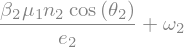

In [ ]:
pom2_dot_res = to_orbelts(-chain_rule(H_expr, Gam2)).subs(a2, n2 ** Rational(-2, 3))
pom2_dot_res

### $\dot\lambda_1$, $\dot\lambda_2$

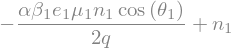

In [ ]:
l1_dot_res = (
    to_orbelts(chain_rule(H_expr, Lam1))
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
l1_dot_res

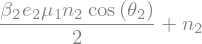

In [ ]:
l2_dot_res = (
    to_orbelts(
        chain_rule(
            H_expr.subs(b2 / a2, b2 * alpha / a1).subs(b1 / a2, b1 * a1 / alpha), Lam2
        )
    )
    .subs(a1, alpha * a2)
    .subs(a2, n2 ** Rational(-2, 3))
)
l2_dot_res

### $\dot e_1$, $\dot e_2$

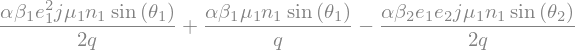

In [ ]:
# edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
e1_dot_res = (
    to_orbelts(
        Gam1_dot_res / (Lam1 * e1)
        - term_multiply(Lam1_dot_res, Rational(1, 2) / Lam1 * e1)
    )
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
e1_dot_res

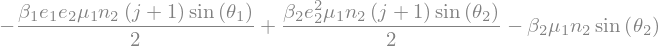

In [ ]:
e2_dot_res = to_orbelts(
    Gam2_dot_res / (Lam2 * e2) - term_multiply(Lam2_dot_res, Rational(1, 2) / Lam2 * e2)
).subs(a2, n2 ** Rational(-2, 3))
e2_dot_res

### $\dot\theta_0$

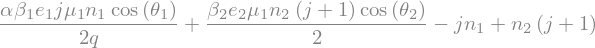

In [ ]:
th0_dot_res = term_multiply(l2_dot_res, j + 1) - term_multiply(l1_dot_res, j)
th0_dot_res

## Secular

### $\dot e_{1,\rm sec}$, $\dot e_{2,\rm sec}$

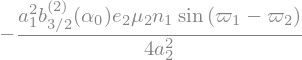

In [ ]:
e1_dot_sec = -R1.diff(pom1).subs(alpha, a1 / a2) / (n1 * a1**2 * e1)
e1_dot_sec

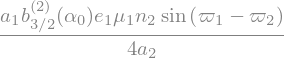

In [ ]:
e2_dot_sec = -R2.diff(pom2).subs(alpha, a1 / a2) / (n2 * a2**2 * e2)
e2_dot_sec

### $\dot \varpi_{1,\rm sec}$, $\dot \varpi_{2,\rm sec}$

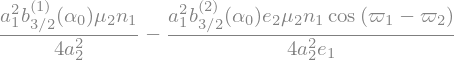

In [ ]:
pom1_dot_sec = term_multiply(R1.diff(e1), 1 / (n1 * a1**2 * e1)).subs(alpha, a1 / a2)
pom1_dot_sec

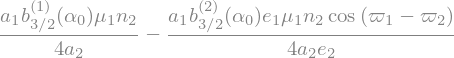

In [ ]:
pom2_dot_sec = term_multiply(R2.diff(e2), 1 / (n2 * a2**2 * e2)).subs(alpha, a1 / a2)
pom2_dot_sec

## Dissipative

### $\dot a_{1,\rm dis}$, $\dot a_{2,\rm dis}$

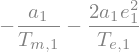

In [ ]:
a1_dot_dis = term_multiply(-1 / Tm1 - 2 * e1**2 / Te1, a1)
a1_dot_dis

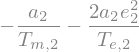

In [ ]:
a2_dot_dis = term_multiply(-1 / Tm2 - 2 * e2**2 / Te2, a2)
a2_dot_dis

### $\dot n_{1,\rm dis}$, $\dot n_{2,\rm dis}$

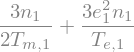

In [ ]:
n1_dot_dis = term_multiply(a1_dot_dis, -Rational(3, 2) * n1 / a1)
n1_dot_dis

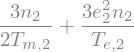

In [ ]:
n2_dot_dis = term_multiply(a2_dot_dis, -Rational(3, 2) * n2 / a2)
n2_dot_dis

### $\dot e_{1,\rm dis}$, $\dot e_{2,\rm dis}$

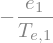

In [ ]:
e1_dot_dis = -e1 / Te1
e1_dot_dis

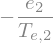

In [ ]:
e2_dot_dis = -e2 / Te2
e2_dot_dis

# RHS for integrations

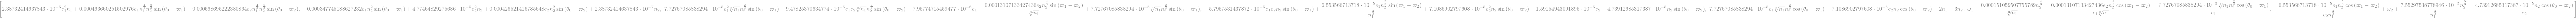

In [73]:
convs = {
    th1: th0 - pom1,
    th2: th0 - pom2,
    a1: n1 ** -Rational(2, 3),
    a2: n2 ** -Rational(2, 3),
    alpha: a1 / a2,
}
params = {
    j: 2,
    mu1: 2.5e-5,
    mu2: 5e-5,
    b1: 1.5455341716765871,
    b2: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    Tm1: np.inf,  # n_{2,0}^{-1}
    Tm2: 1e6 * 2 * np.pi,
}
params[q] = params[mu1] / params[mu2]
params[Te2] = params[Tm2] * 0.01
params[Te1] = params[Te2] / q

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)


_ = [
    n1_dot_res + n1_dot_dis,
    n2_dot_res + n2_dot_dis,
    e1_dot_res + e1_dot_sec + e1_dot_dis,
    e2_dot_res + e2_dot_sec + e2_dot_dis,
    th0_dot_res,
    pom1_dot_res + pom1_dot_sec,
    pom2_dot_res + pom2_dot_sec,
]
funs = [iterfun.subs(convs).subs(params).subs(convs) for iterfun in _]

xp = [n1, n2, e1, e2, th0, pom1, pom2, om1, om2]
funs

In [74]:
#lambdastr(xp, funs).replace("math", "npy")

In [79]:
def solve_ivp(job):
    ind, omega_1, omega_2, theta0, varpi10, varpi20 = (
        job[0],
        job[1],
        job[2],
        job[3],
        job[4],
        job[5],
    )

    funcl = lambdify(xp, funs)

    def func(t, x0):
        return funcl(*x0, omega_1, omega_2)

    def event1(t, Y):
        return Y[1] / Y[0] - 0.8

    event1.terminal = True

    teval = npy.linspace(0, 2 * npy.pi * 1e5, 10000)
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [1.65, 1, 0.001, 0.001, theta0, varpi10, varpi20],
        t_eval=teval,
        rtol=1e-9,
        atol=1e-9,
        method="DOP853",
        events=[event1],
    )
    return sol

In [85]:
omega0 = 1e-2
sol = solve_ivp([0, omega0 * alpha0val**3.5, omega0, 0, 0, 0])

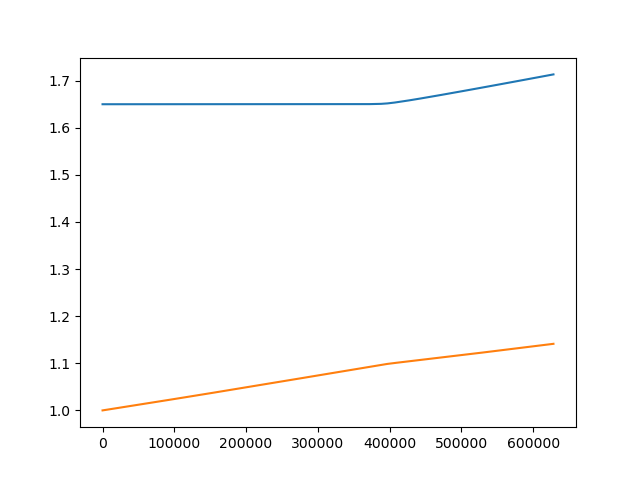

In [84]:
plt.clf()
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.show()